# Heralding and post-selection
- Two useful tools for photonic quantum computing are heralding and post-selection. These can be included in the emulator using some built-in options for the sampler.

In [1]:
import lightworks as lw
from lightworks import emulator, State

import numpy as np
import matplotlib.pyplot as plt

### Heralding
- First start with heralding. 
- We show how this can be applied in the case of the RALPH CNOT gate, as described in https://arxiv.org/abs/quant-ph/0112088.
- This a two photon, 6 mode, CNOT gate, which relies on measuring one photon between modes 1 and 2, one photon between modes 3 and 4, and no photons on modes. We can use the built-in heralding to enforce all of these conditions by providing a function.
- First need to start by building the circuit as below: 

In [2]:
circ = lw.Circuit(6)

r = 1/3
theta = np.arccos(r)

circ.add_bs(0)
circ.add_ps(0, theta)
circ.add_bs(0)

circ.add_bs(3)
circ.add_ps(3, np.pi/2)
circ.add_bs(3)

circ.add_bs(2)
circ.add_ps(2, theta)
circ.add_bs(2)
circ.add_ps(3, np.pi)

circ.add_bs(4)
circ.add_ps(4, theta)
circ.add_bs(4)

circ.add_bs(3)
circ.add_ps(3, np.pi/2)
circ.add_bs(3)

- We can then build the heralding function, it is possible for this to either be a traditional python function or a lambda function.
- When switching these, it can be seen that either work effectively.
- Notice that here, we are also effectively post-selecting for a photon number of two.

In [3]:
herald_func = lambda s: (s[0] == 0 and (s[1] + s[2]) == 1 and 
                         (s[3] + s[4]) == 1 and s[5] == 0)

def herald_func(s):
    return (s[0] == 0 and (s[1] + s[2]) == 1 and (s[3] + s[4]) == 1 and 
            s[5] == 0)

- Once the heralding function is defined, we can then define the possible input/output states, and we will use the sampler to look at the counts in each case.

In [4]:
N_rep = 100000

inputs = {"00" : State([0,1,0,1,0,0]),
          "01" : State([0,1,0,0,1,0]),
          "10" : State([0,0,1,1,0,0]),
          "11" : State([0,0,1,0,1,0])}

results = {}
for i, state in inputs.items():
    sampler = emulator.Sampler(circ, state)
    counts = sampler.sample_N(N_rep, herald = herald_func)
    results[i] = [c/max(counts) for c in counts] # Normalise to 1

- We then plot the results below. From this it is possible to confirm that the CNOT behaves as expected.

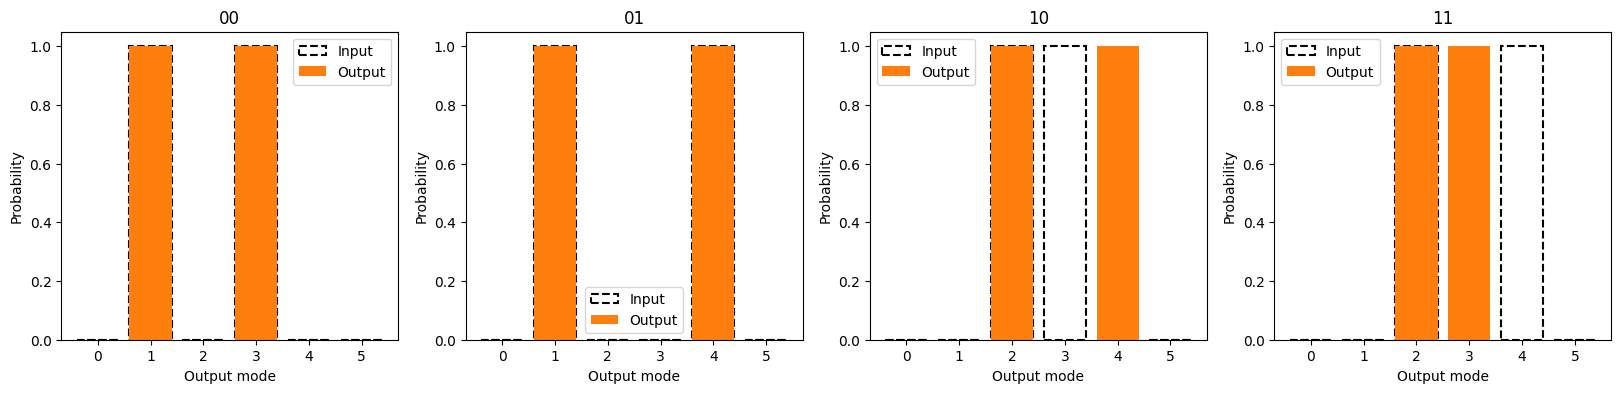

In [5]:
fig, ax = plt.subplots(1, 4, figsize = (20,4))

x = range(circ.n_modes)
for i, label, in_state in zip(range(len(inputs)), inputs, inputs.values()):
    ax[i].bar(x, [s for s in in_state.s], label = "Input", edgecolor = "Black", 
              fill = False, linestyle = "dashed", linewidth = 1.5)
    ax[i].bar(x, results[label], label = "Output")
    ax[i].set_xlabel("Output mode")
    ax[i].set_ylabel("Probability")
    ax[i].legend()
    ax[i].set_title(label)
    
plt.show()

### Post-selection
- The other function to look at is post-selection. To do this we will choose to examine a lossy bell-state generator, similar to that shown on page 3 of https://arxiv.org/pdf/2106.13825.pdf.
- The circuit for this can be built in the following way, in which modes 0-3 are the inputs, all containing a single photon and modes 4-7 are ancilla. This is not a physical circuit, and instead some re-arrangement of the modes would be required.

In [6]:
circ = lw.Circuit(8)

loss = 0.35

for i in range(4):
    circ.add_bs(i, 4+i, loss = loss)
    circ.add_ps(i, np.pi/2)
    circ.add_bs(i, 4+i, loss = loss)
    
circ.add_bs(4, 5, loss = loss)
circ.add_ps(4, np.pi/2)
circ.add_bs(4, 5, loss = loss)

circ.add_bs(6, 7, loss = loss)
circ.add_ps(6, np.pi/2)
circ.add_bs(6, 7, loss = loss)

circ.add_bs(5, 6, loss = loss)
circ.add_ps(5, 0)
circ.add_bs(5, 6, loss = loss)

circ.add_bs(4, 5, loss = loss)
circ.add_ps(4, np.pi/2)
circ.add_bs(4, 5, loss = loss)

circ.add_bs(6, 7, loss = loss)
circ.add_ps(6, np.pi/2)
circ.add_bs(6, 7, loss = loss)

circ.add_bs(5, 6, loss = loss)
circ.add_ps(5, 0)
circ.add_bs(5, 6, loss = loss)

- In this case, we use the heralding function to select a particular measurement outcome from the ancilla modes. 
- We then use the post_select option to ensure that 4 photons total leave the circuit.
- In this case, we choose to use the sample_N_states function, as it enables us to get the number of times we see each output state, instead of just the measured photon counts.

In [7]:
in_state = State([1, 1, 1, 1, 0, 0, 0, 0])
herald_func = lambda s: s[4] == 1 and s[5] == 1 and s[6] == 0 and s[7] == 0

sampler = emulator.Sampler(circ, in_state)

In [9]:
N_rep = 100000

results = sampler.sample_N_states(N_rep, herald = herald_func, post_select = 4)
states, counts = [], []
for s, c in results.items():
    states.append(s[:4])
    counts.append(c)

- As can be seen from the plot below, for the measurement pattern [1,1,0,0] on the ancilla modes, we usually get the states |1,0,0,1> and |0,1,1,0> across the other 4 modes, which is as expected. If we convert this to dual rail encoded qubits, then this corresponds to the state |01> + |10>, which is a bell state, showing the generator works correctly.
- Interestingly though, we can see the effect of loss here as it leads so some errors presenting themselves in the operation.

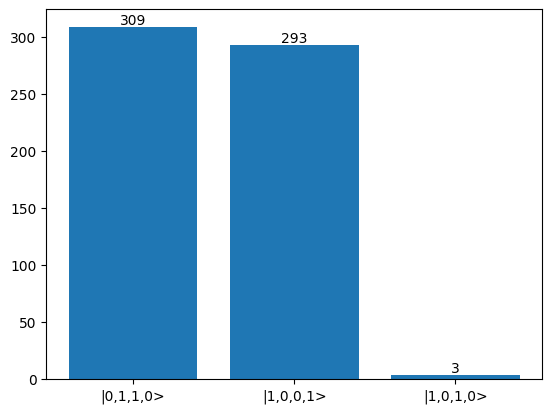

In [10]:
bars = plt.bar(range(len(states)), counts)
plt.bar_label(bars, counts)
plt.xticks(range(len(states)), states)
plt.show()